# Attack Tag Classification
In this notebook, I go through the process of data cleaning, data transformation, feature engineering ,and model building for the task of classifying the 148 missing attack tags in the honeypot data. This missing data was brought to my attention while analyzing the tags field. My intuition is that if we can find a way to properly encode the payload data, while retaining it's semantic information, then we can combine this with other fields to predict what the missing tag must be.

The contents of this page are as follows:

    1) Load Data
    2) Data Cleaning and Preprocessing
    3) Feature Engineering
        a) Create separate Octets from IP Address
        b) Fasttext encoding of Payload
        c) Encode and Scale remaining variables
    4) Model Selection
    5) Hyperparameter Tuning
    6) Model Training
    7) Performance Evaluation
        a) Classification Report
        b) Confusion Matrix Heatmap
    8) Implement model on unknown tags
    

In [366]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,f1_score
from gensim.models import FastText
import re

## Load Dataset

In [491]:
honeypot_df = pd.read_json('honeypot.json')

#Change tags field from list to string
honeypot_df['tags'] = honeypot_df['tags'].apply(lambda x: ' '.join(x))

honeypot_df.head(100)

,timestamp,tags,payload,port,country_name,as_num,proxy_type,ip,country_name_1
0,2023-04-12 22:28:12.843000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,3.8.237.65,United Kingdom
1,2023-04-12 22:31:09.462000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,13.42.34.10,United Kingdom
2,2023-04-12 22:15:07.789000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,71.136.70.3,China
3,2023-04-12 22:40:06.014000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,16.50.56.182,Australia
4,2023-04-12 22:35:06.097000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,16.50.61.107,Australia
...,...,...,...,...,...,...,...,...,...
95,2023-04-12 22:02:03.631000+00:00,RDP_SCANNER,\x03\x00\x00+&\xe0\x00\x00\x00\x00\x00Cookie: ...,5000,United Arab Emirates,8075,DCH,89.248.165.167,Netherlands
96,2023-04-12 22:31:51.462000+00:00,RDP_SCANNER,\x03\x00\x00+&\xe0\x00\x00\x00\x00\x00Cookie: ...,5000,United Arab Emirates,8075,DCH,89.248.165.167,Netherlands
97,2023-04-12 22:48:20.761000+00:00,RDP_SCANNER,\x03\x00\x00+&\xe0\x00\x00\x00\x00\x00Cookie: ...,5000,United Arab Emirates,8075,DCH,89.248.165.167,Netherlands
98,2023-04-12 22:03:17.168000+00:00,TCP_SYN,None,5000,United Arab Emirates,8075,DCH,89.248.165.167,Netherlands


### Clean and Preprocess the data 

In [494]:
def clean_text(text):
    # Remove any non-ASCII characters
   
    if text:
        text = text.encode('ascii', 'ignore').decode('ascii')
        text = text.lower()

        # Remove any escape characters
        #text = re.sub(r'\\[xX][\dA-Fa-f]{2}', '', text)
        text = re.sub(r'\\r|\\n', '', text)
        # Remove any special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', '', text).strip()
    else:
        text = '0'
    return text


In [492]:
#replace None payload with a <EMPTY> tag
honeypot_df.payload.fillna("<EMPTY>",inplace=True)

#Change missing tag to unknown
honeypot_df.loc[honeypot_df.tags=='','tags']='unknown'

#Apply cleaning function for payload text
honeypot_df['payload_clean'] = honeypot_df['payload'].apply(clean_text)

In [496]:
honeypot_df

,timestamp,tags,payload,port,country_name,as_num,proxy_type,ip,country_name_1,payload_clean
0,2023-04-12 22:28:12.843000+00:00,ICMP_ECHO_REQUEST,<EMPTY>,0,United Arab Emirates,8075,DCH,3.8.237.65,United Kingdom,empty
1,2023-04-12 22:31:09.462000+00:00,ICMP_ECHO_REQUEST,<EMPTY>,0,United Arab Emirates,8075,DCH,13.42.34.10,United Kingdom,empty
2,2023-04-12 22:15:07.789000+00:00,ICMP_ECHO_REQUEST,<EMPTY>,0,United Arab Emirates,8075,DCH,71.136.70.3,China,empty
3,2023-04-12 22:40:06.014000+00:00,ICMP_ECHO_REQUEST,<EMPTY>,0,United Arab Emirates,8075,DCH,16.50.56.182,Australia,empty
4,2023-04-12 22:35:06.097000+00:00,ICMP_ECHO_REQUEST,<EMPTY>,0,United Arab Emirates,8075,DCH,16.50.61.107,Australia,empty
...,...,...,...,...,...,...,...,...,...,...
49995,2023-04-12 22:00:06.974000+00:00,RDP_SCANNER,\x03\x00\x00+&\xe0\x00\x00\x00\x00\x00Cookie: ...,34061,Japan,45102,DCH,60.171.93.25,China,x03x00x00xe0x00x00x00x00x00cookiemstshashhello...
49996,2023-04-12 22:03:56.097000+00:00,TCP_SYN,<EMPTY>,64189,Japan,45102,DCH,60.171.93.25,China,empty
49997,2023-04-12 22:20:09.016000+00:00,RDP_SCANNER,\x03\x00\x00+&\xe0\x00\x00\x00\x00\x00Cookie: ...,64553,Japan,45102,DCH,60.171.93.25,China,x03x00x00xe0x00x00x00x00x00cookiemstshashhello...
49998,2023-04-12 22:20:14.965000+00:00,RDP_SCANNER,\x03\x00\x00+&\xe0\x00\x00\x00\x00\x00Cookie: ...,1985,Japan,45102,DCH,60.171.93.25,China,x03x00x00xe0x00x00x00x00x00cookiemstshashhello...


In [498]:
#remove because only 1 occurence of each tag in the whole dataset
remove_rows = honeypot_df.tags.value_counts().tail(8).keys()

In [499]:
remove_rows

Index(['ZGRAB_SCANNER HTTP_SCANNER', 'GENERICLINES', 'RTSP_SCANNER',
       'DNS_SCANNER', 'MIRAI MALIGN MALICIOUS BUSYBOX_SCANNER',
       'SMTP_SCANNER EMAIL_SCANNER', 'TOR TCP_SYN', 'SOURCE_ENGINE'],
      dtype='object')

In [500]:
#remove all tags with only 1 occurence in the whole dataset since these are outliers
for i in remove_rows:
    honeypot_df = honeypot_df[honeypot_df['tags'] != i]

In [501]:
honeypot_df = honeypot_df.drop('timestamp', axis=1)
honeypot_df_test = honeypot_df[honeypot_df['tags'] == 'unknown']
honeypot_df = honeypot_df[honeypot_df['tags'] != 'unknown']

In [502]:
#removing proxy_type field since 99% is DCH. Information gain from this field is minimal
honeypot_df.drop('proxy_type', axis=1,inplace=True)

# Feature Engineering

### Separating Octets of IP field

In [503]:
#Create new features from IP address field. This allows us to treat each 
honeypot_df[['octet_1', 'octet_2', 'octet_3', 'octet_4']] = honeypot_df['ip'].str.split('.', expand=True)
honeypot_df = honeypot_df.drop(['ip'], axis=1)

In [504]:
honeypot_df['octet_1'] = honeypot_df['octet_1'].astype(int)
honeypot_df['octet_2'] = honeypot_df['octet_2'].astype(int)
honeypot_df['octet_3'] = honeypot_df['octet_3'].astype(int)
honeypot_df['octet_4'] = honeypot_df['octet_4'].astype(int)

In [505]:
honeypot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49844 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tags            49844 non-null  object
 1   payload         49844 non-null  object
 2   port            49844 non-null  int64 
 3   country_name    49844 non-null  object
 4   as_num          49844 non-null  int64 
 5   country_name_1  49844 non-null  object
 6   payload_clean   49844 non-null  object
 7   octet_1         49844 non-null  int32 
 8   octet_2         49844 non-null  int32 
 9   octet_3         49844 non-null  int32 
 10  octet_4         49844 non-null  int32 
dtypes: int32(4), int64(2), object(5)
memory usage: 3.8+ MB


### Train a FastText model on payload field
Here, we train a FastText model and use it to obtain embeddings on each payload.
This allows us to use the learned embeddings to represent the payload information in numerical form while retaining the semanitc information inherent in the textual form.

In [506]:
#Train Fasttext
unique_payload = list(set(honeypot_df['payload_clean'].tolist()))
ft_model = FastText(unique_payload, window=5, min_count=1, workers=4)

In [507]:
honeypot_df = honeypot_df.drop(['payload'], axis=1)

In [508]:
honeypot_df['payload_vectors'] = sentence_vectorizer(honeypot_df['payload_clean'], ft_model)

In [509]:
honeypot_df = honeypot_df.drop(['payload_clean'], axis=1)

In [510]:
def sentence_vectorizer(tokenized_sentences, model):
    sentence_vectors = []
    for tokens in tokenized_sentences:
        word_vectors = np.array([model.wv[token] for token in tokens])
        sentence_vector = np.mean(word_vectors, axis=0)
        sentence_vectors.append(sentence_vector)
    return sentence_vectors

### Preparing the variables for encoding and scaling

In [769]:
categorical_columns = ['country_name','country_name_1']
numerical_columns = ['port','octet_1','octet_2','octet_3','octet_4', 'as_num']
target_column = 'tags'

In [770]:
X = honeypot_df[categorical_columns + numerical_columns + ['payload_vectors']]
y = honeypot_df[target_column]

In [513]:
#label encode target
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)



In [515]:
# Preprocessing for categorical columns 
cat_enc = OneHotEncoder(handle_unknown='ignore')
cat_encoded = cat_enc.fit_transform(X[categorical_columns]).toarray()

# Preprocessing for numerical columns
num_scaler = StandardScaler()
num_scaled = num_scaler.fit_transform(X[numerical_columns])

# Combine transformed data
fasttext_vectors = np.concatenate(X['payload_vectors'].to_numpy()).reshape(-1, 100)
X_train_processed = np.hstack((cat_encoded, num_scaled, fasttext_vectors))


# Model Selection

Here, I try out different Machine Learning classification models to see which one fits the data the best.

In [756]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

# Define k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define models to evaluate
models = [('LogisticRegression', LogisticRegression(random_state=42, max_iter=500)),
          ('Random Forest', RandomForestClassifier()),
          ('SVC', svm.SVC()),
          ('KNN', KNeighborsClassifier())
    
]

# Evaluate each model using cross-validation
results = []
names = []
              
for name, model in models:
              
    # Define macro F1 score as the metric
    scoring = make_scorer(f1_score, average='macro')
              
    # Evaluate the model using k-fold cross-validation
    cv_results = cross_val_score(model, X_train_processed, y_encoded , cv=kf, scoring=scoring)
              
    results.append(cv_results)
    names.append(name)
    # Print results for each model
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LogisticRegression: 0.739675 (0.163394)
Random Forest: 0.795617 (0.099776)
SVC: 0.705562 (0.153947)
KNN: 0.659485 (0.117626)


Shown above is the mean performance of each model on macro averaged F1 score. This metric is used since it gives each class equal importance in a class imabalanced problem. This will be helpful in determining the true performance of the model.

Below is a visual representation of this performance of different algorithms that were tested.

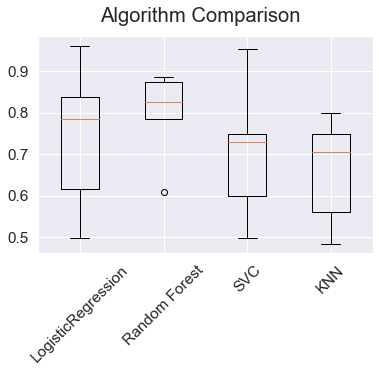

In [758]:
# Compare models using boxplots
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,rotation=45)
plt.show()

Random Forest appears to fit this data better than the other algorithms. Hence, this classifer is chosen and will be fine tuned on the data set to create a better fit on the data. This process is known as Hyperparameter tuning.

## Hyperparameter Tuning

The various parameters that determine the models performance are tuned in this section. This phase is important to fit the model correctly to the given data. This phase has to be done carefully since there is a chance that the model will fit to the data almost too well, leading to overfitting. To avoid this, KFolf cross validation is done for each parameter set that is tested.

In [544]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with k-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kfold, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_train_processed, y_encoded)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 28.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro', verbose=2)

## Model Training

In [514]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_processed, y_encoded, test_size=0.2, random_state=42)


In [768]:
# Find the best hyperparameter configuration
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test_processed)
test_accuracy = f1_score(y_test, y_pred,average='macro')
print(f"Test f1 score: {test_accuracy:.4f}")

Best hyperparameters: {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Test f1 score: 0.8960


### Save all encoders and model as a file

This is helpful for when the model and all associated encoders have to be deployed in the future

In [651]:
# Save the trained classifier and encoders using pickle
import pickle
with open('model/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('model/label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)
    
with open('model/fasttext.pkl', 'wb') as ft_file:
    pickle.dump(ft_model, ft_file)
    
    
with open('model/cat_encoder.pkl', 'wb') as cat_file:
    pickle.dump(cat_enc, cat_file)
with open('model/num_scaler.pkl', 'wb') as num_file:
    pickle.dump(num_scaler, num_file)

# Model Performance Evaluation

### 1) Classification Report

In [637]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

# Make predictions

adjusted_test = [x if len(x)<12 else x[:12] for x in label_encoder.inverse_transform(y_test) ]
adjusted_pred = [x if len(x)<12 else x[:12] for x in label_encoder.inverse_transform(y_pred) ]
# Evaluate the model using classification_report
print(classification_report(adjusted_test, adjusted_pred))

              precision    recall  f1-score   support

HTTP_REFLECT       1.00      1.00      1.00         5
HTTP_SCANNER       1.00      1.00      1.00        38
ICMP_ECHO_RE       1.00      1.00      1.00        81
PROXY_SCANNE       1.00      1.00      1.00        28
 RDP_SCANNER       1.00      1.00      1.00      4758
SIP_SCANNER        1.00      1.00      1.00         1
 SMB_SCANNER       0.00      0.00      0.00         1
 SSL_SCANNER       0.92      1.00      0.96        12
     TCP_SYN       1.00      1.00      1.00      5032
TECHNOLOGY_M       1.00      1.00      1.00        13

    accuracy                           1.00      9969
   macro avg       0.89      0.90      0.90      9969
weighted avg       1.00      1.00      1.00      9969



C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


According to the classification report, it is seen that the model is performing quite well on this test data.
Next, we can view this data in a more visual way to gain more insights into the model performance.

### 2) Confusion Matrix

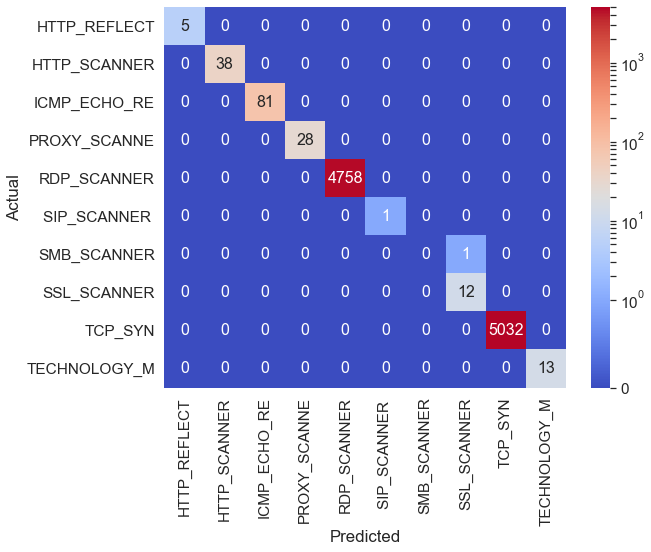

In [630]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import FixedLocator, ScalarFormatter, FuncFormatter

y_true = adjusted_test
y_pred = adjusted_pred

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

data = cm
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (9,7))
sns.set(font_scale=1.4) #for label size

# Define a custom logarithmic normalization for the color map
min_val = np.min(df_cm.min())  # Find the smallest positive value in the data
max_val = np.max(df_cm.max())
linthresh = 1  # Set the linear threshold value
linscale = 1   # Set the linear scale value
norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=min_val, vmax=max_val, base=10)


ax = sns.heatmap(df_cm, cmap="coolwarm", annot=True,annot_kws={"size": 16},fmt='g',norm=norm)# font size

# Create custom ticks and labels
plt.show()

The confusion matrix shows that the model is able to correctly predict the labels for all but one instance, where it predicted SSL_SCANNER when the actual label was SMB_SCANNER.

Note that most of the test set contained the tags TCP_SYN and RDP_SCANNER. This is reflective of the distribution of the data in the honeypot.JSON file. The fact that the model has a macro averaged F1 score of 0.89 means that it has generalized well over this imbalanced dataset. The missing 0.11 of f1 score seems to be due to the missclassification of the SMB_SCANNER tag as mentioned above.

### Limitation:
- Can only predict labels it was trained on. To predict new labels, other methods such as anomaly detection must be used to generate tags based on new clusters found

- Since honeypot.json is only a subset of the True honeypot dataset, this model may not perform well on this larger dataset. However, this framework can be seen as a PoC of how we can build models that generalize to this type of data.


# Implement model on unknown tags

Now, this trained model can be used to predict the tags that were missing in the honeypot.JSON file. First, I will put together everything explained in this notebook into a pipeline, and then use this pipeline to come up with the predictions.

In [763]:
import pickle

class attack_tagger:
    def __init__(self, df_to_tag):
            
        self.honeypot_df = pd.DataFrame(df_to_tag)

         #load files
        self.model = self.unpickle_file('model/random_forest_model.pkl')
        self.label_encoder = self.unpickle_file('model/label_encoder.pkl')
        self.ft_model = self.unpickle_file('model/fasttext.pkl')
        self.cat_enc = self.unpickle_file('model/cat_encoder.pkl')
        self.num_scaler = self.unpickle_file('model/num_scaler.pkl')


        self.preprocess()
        self.data = self.transform()    
   
    def predict_tags(self):
        """
            Predicts tags for instances in the dataset using a pre-trained model.

            This function uses the pre-trained model to predict tags for instances in the dataset. 
            The predicted tags are then transformed back to their original labels using an inverse transformation.

            Parameters
            ----------
            None

            Returns
            -------
            predicted_tags : array-like
                An array containing the predicted tags for each instance in the dataset.
        """
        predicted_tags = self.model.predict(self.data)
        predicted_tags = self.label_encoder.inverse_transform(predicted_tags)
        
        return predicted_tags
    
    def clean_text(self,text):
        """
        Cleans the input text by removing non-ASCII characters, escape characters, and special characters.

        This function takes a string as input and performs the following operations:
            1. Removes non-ASCII characters.
            2. Converts the text to lowercase.
            3. Removes escape characters.
            4. Removes special characters.
            5. Trims extra whitespace.

        If the input text is empty or None, the function returns '0'.

        Parameters
        ----------
        text : str
            The input text to be cleaned.

        Returns
        -------
        text : str
            The cleaned text.
        """
    # Remove any non-ASCII characters
   
        if text:
            text = text.encode('ascii', 'ignore').decode('ascii')
            text = text.lower()

            # Remove any escape characters
            text = re.sub(r'\\r|\\n', '', text)
            # Remove any special characters
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            text = re.sub(r'\s+', '', text).strip()
        else:
            text = '0'
        return text
    

    def unpickle_file(self,path=''):
        '''Loads a pickled object from a file.'''
        
        f = open(path,"rb")
        unpickled = pickle.load(f)
        f.close()
        return unpickled
    

    def sentence_vectorizer(self,payload_sentences, model):
        """
        Converts a list of payload sentences into sentence vectors using a pre-trained model.

        This function iterates over the payload sentences, computes the word vectors for each token 
        using the given model, calculates the mean of the word vectors to form a sentence vector, 
        and appends it to a list of sentence vectors.

        Parameters
        ----------
        payload_sentences : list of lists of str
            A list of payload sentences.

        model : Word2Vec, FastText, or similar
            A pre-trained word embedding model to generate word vectors for tokens.

        Returns
        -------
        sentence_vectors : list of ndarray
            A list of sentence vectors, where each sentence vector is a NumPy ndarray.
        """
        sentence_vectors = []
        for tokens in payload_sentences:
            word_vectors = np.array([model.wv[token] for token in tokens])
            sentence_vector = np.mean(word_vectors, axis=0)
            sentence_vectors.append(sentence_vector)
        return sentence_vectors
    
    def preprocess(self):
        """
        Preprocesses the honeypot dataset by cleaning and transforming various features.

        This function performs the following preprocessing steps:
        1. Replaces missing payload values with '<EMPTY>'.
        2. Cleans the payload and stores the cleaned payload in a new column called 'payload_clean'.
        3. Drops the 'timestamp' and 'proxy_type' columns.
        4. Splits the IP address into 4 octets, storing each octet as an integer in separate columns.

        No parameters required, as this function operates on the instance's honeypot_df attribute.

        Returns
        -------
        None
        """
        
        self.honeypot_df.payload.fillna("<EMPTY>",inplace=True)
        self.honeypot_df['payload_clean'] = self.honeypot_df['payload'].apply(self.clean_text)        

        self.honeypot_df = self.honeypot_df.drop('timestamp', axis=1)
        self.honeypot_df.drop('proxy_type', axis=1,inplace=True)
        self.honeypot_df[['octet_1', 'octet_2', 'octet_3', 'octet_4']] = self.honeypot_df['ip'].str.split('.', expand=True)
        self.honeypot_df = self.honeypot_df.drop(['ip'], axis=1)
        
        self.honeypot_df['octet_1'] = self.honeypot_df['octet_1'].astype(int)
        self.honeypot_df['octet_2'] = self.honeypot_df['octet_2'].astype(int)
        self.honeypot_df['octet_3'] = self.honeypot_df['octet_3'].astype(int)
        self.honeypot_df['octet_4'] = self.honeypot_df['octet_4'].astype(int)
        
        
        
    def transform(self):
        """
        Transforms the honeypot dataset by encoding categorical features, scaling numerical features, 
        and applying FastText to the payload feature.

        This function performs the following transformation steps:
        1. Vectorizes the 'payload_clean' column using FastText and stores the result in a new column 'payload_vectors'.
        2. Drops the 'payload_clean' column.
        3. Encodes categorical columns using the instance's cat_enc attribute (OneHotEncoder).
        4. Scales numerical columns using the instance's num_scaler attribute (StandardScaler).
        5. Combines the transformed data into a single NumPy array.

        No parameters required, as this function operates on the instance's honeypot_df attribute.

        Returns
        -------
        X_processed : numpy.ndarray
            Transformed dataset with encoded categorical features, scaled numerical features, and FastText payload vectors.
        """
        
        #separate out the columns
        categorical_columns = ['country_name','country_name_1']
        numerical_columns = ['port','octet_1','octet_2','octet_3','octet_4', 'as_num']
        
        #apply fasttext to payload
        self.honeypot_df['payload_vectors'] = self.sentence_vectorizer(self.honeypot_df['payload_clean'], self.ft_model)
        self.honeypot_df = self.honeypot_df.drop(['payload_clean'], axis=1)
        
        
        X = self.honeypot_df[categorical_columns + numerical_columns + ['payload_vectors']]
        
        # Encoding categorical columns
        cat_encoded = self.cat_enc.transform(X[categorical_columns]).toarray()
        
        # Scaling numerical columns
        num_scaled = self.num_scaler.transform(X[numerical_columns])
        
        # Combine transformed data        
        fasttext_vectors = np.concatenate(X['payload_vectors'].to_numpy()).reshape(-1, 100)
        X_processed = np.hstack((cat_encoded, num_scaled, fasttext_vectors))
        
        return X_processed            
        
        

In [744]:
# Read json file into dataframe and extract the data to tag on
hp = pd.read_json("honeypot.json")
df_to_tag=pd.DataFrame(hp.iloc[honeypot_df_test.index.values])
#honeypot_df_test was separated from the training data early on so there is no overlap between unseen test data and trained data

In [761]:
#Call the attack_tagger class, which is the model execution pipeline, and predict the tags
tagger = attack_tagger(df_to_tag,ft_model).predict_tags()

In [762]:
#model predicitons
tagger

array(['PROXY_SCANNER', 'PROXY_SCANNER', 'PROXY_SCANNER', 'PROXY_SCANNER',
       'RDP_SCANNER', 'HTTP_SCANNER', 'HTTP_SCANNER', 'HTTP_SCANNER',
       'TCP_SYN', 'HTTP_REFLECTION HTTP_SCANNER',
       'TECHNOLOGY_MICROSOFT_REMOTE_DESKTOP_2019 RDS_SCANNER RDP_SCANNER TECHNOLOGY_MICROSOFT_REMOTE_DESKTOP_2016 TECHNOLOGY_MICROSOFT_REMOTE_DESKTOP_2022',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCANNER',
       'SSL_SCANNER', 'SSL_SCANNER', 'SSL_SCA

In [764]:
#set the predicitons as the tags field 
df_to_tag['tags']=tagger

In [765]:
#view dataframe with new predicitons
df_to_tag

,timestamp,tags,payload,port,country_name,as_num,proxy_type,ip,country_name_1,payload_clean
283,2023-04-12 22:05:27.486000+00:00,PROXY_SCANNER,\x01!\x01\x01\x01\x01\x01\x01,18080,United States,14618,DCH,162.218.65.102,United States,x01x01x01x01x01x01x01
285,2023-04-12 22:51:01.427000+00:00,PROXY_SCANNER,\x01!\x01\x01\x01\x01\x01\x01,18080,United States,14618,DCH,209.222.252.24,United States,x01x01x01x01x01x01x01
286,2023-04-12 22:51:58.761000+00:00,PROXY_SCANNER,\x01!\x01\x01\x01\x01\x01\x01,18080,United States,14618,DCH,209.222.252.34,United States,x01x01x01x01x01x01x01
471,2023-04-12 22:18:17.783000+00:00,PROXY_SCANNER,\x01!\x01\x01\x01\x01\x01\x01,18080,United States,14618,DCH,91.198.115.170,Netherlands,x01x01x01x01x01x01x01
1511,2023-04-12 22:42:57.567000+00:00,RDP_SCANNER,\x00\x0bn\x00\x00\x00\x00\x01\x04beio,10255,United States,63949,DCH,178.79.179.84,United Kingdom,x00x0bnx00x00x00x00x01x04beio
...,...,...,...,...,...,...,...,...,...,...
31540,2023-04-12 22:24:18.578000+00:00,SSL_SCANNER,\x04\x01\x00P\x8e\xfb\xde\xce\x00,61286,Malaysia,45102,DCH,103.141.138.246,Vietnam,x04x01x00px8exfbxdexcex00
31544,2023-04-12 22:51:39.676000+00:00,SSL_SCANNER,\x04\x01\x00P\x8e\xfb\xde\xce\x00,61947,Malaysia,45102,DCH,103.141.138.246,Vietnam,x04x01x00px8exfbxdexcex00
31546,2023-04-12 22:33:04.419000+00:00,SSL_SCANNER,\x04\x01\x00P\x8e\xfa\xccn\x00,27100,Malaysia,45102,DCH,103.141.138.246,Vietnam,x04x01x00px8exfaxccnx00
31548,2023-04-12 22:45:16.854000+00:00,SSL_SCANNER,\x04\x01\x00P\x8e\xfb\xde\xce\x00,27395,Malaysia,45102,DCH,103.141.138.246,Vietnam,x04x01x00px8exfbxdexcex00


### Analyzing the predictions

Looking into some of these predictions, I noticed that some payload data that was being tagged as HTTP_SCANNER did not look like http code at all. This seems more likely to be related to a cryptocurrency mining operation, specifically using the XMRig miner.

The cell above can be taken as an example of this current ML method's misprediction. This could be an instance of an attack previously not seen in this subset of data (honeypot.json). 

In [766]:
df_to_tag[df_to_tag.tags=='HTTP_SCANNER'].payload.values

array(['\\x81\\x00\\x00D DEDFCODDDDCODGDJCODEDECACACACACA\\x00 CACACACACACACACACACACACACACACAAA\\x00',
       '{"id":1,"jsonrpc":"2.0","method":"login","params":{"login":"42pFDFzXPF8FRMrzMktS6dXuHx21uY6Z1HknFR5j3aGZVMubwzWePdQd1p2J9goMrDG3Vz2ToMKsbR8rxuGr3d769N17cLJ","pass":"x","agent":"XMRig/6.16.2 (Windows NT 10.0; Win64; x64) libuv/1.42.0 msvc/2019","algo":["cn/1","cn/2","cn/r","cn/fast","cn/half","cn/xao","cn/rto","cn/rwz","cn/zls","cn/double","cn/ccx","cn-lite/1","cn-heavy/0","cn-heavy/tube","cn-heavy/xhv","cn-pico","cn-pico/tlo","cn/upx2","rx/0","rx/wow","rx/arq","rx/graft","rx/sfx","rx/keva","argon2/chukwa","argon2/chukwav2","argon2/ninja","astrobwt","ghostrider"]}}\\n',
       '{"id":1,"jsonrpc":"2.0","method":"login","params":{"login":"42pFDFzXPF8FRMrzMktS6dXuHx21uY6Z1HknFR5j3aGZVMubwzWePdQd1p2J9goMrDG3Vz2ToMKsbR8rxuGr3d769N17cLJ","pass":"x","agent":"XMRig/6.16.2 (Windows NT 10.0; Win64; x64) libuv/1.42.0 msvc/2019","algo":["cn/1","cn/2","cn/r","cn/fast","cn/half","cn/xao","cn

--------------------------------------------------------------------------------------------------------------------
## **Future Scope** : **Detecting Zero Day threats**

To test out the idea of detecting new tags, I would like to implement unsupervised clustering to detect any new clusters being formed. This type of ML is called Anomaly Detection. 

This procedure could be very helpful in detecting zero day threats. More research will have to be done to test out the viability of this idea.